# Sing2Ani Training Pipeline

### Dataset Configuration

In [1]:
%matplotlib inline

import os
import time
from pathlib import Path
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pydub import AudioSegment

from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import torch.nn as nn

from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
from torch.optim.lr_scheduler import ReduceLROnPlateau

print(torch.__version__)
print(torchaudio.__version__)

import librosa

from IPython.display import Audio
from torchaudio.utils import download_asset

torch.random.manual_seed(0)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

TRAINING_DATA_PATH = "C:/Users/Kevin/AppData/LocalLow/kevinjycui/Training"
TESTING_DATA_PATH = "C:/Users/Kevin/AppData/LocalLow/kevinjycui/Testing"

BLENDSHAPE_PARAMS = ["A", "Angry", "Blink", "Blink_L", "Blink_R", "E", "Fun", "I", "Joy", "LookDown", "LookLeft", "LookRight", "LookUp", "Neutral", "O", "Sorrow", "Surprised", "U"]
BONE_PARAMS = ["Chest", "Head", "Hips", "LeftEye", "LeftFoot", "LeftHand", "LeftIndexDistal", "LeftIndexIntermediate", "LeftIndexProximal", "LeftLittleDistal", "LeftLittleIntermediate", "LeftLittleProximal", "LeftLowerArm", "LeftLowerLeg", "LeftMiddleDistal", "LeftMiddleIntermediate", "LeftMiddleProximal", "LeftRingDistal", "LeftRingIntermediate", "LeftRingProximal", "LeftShoulder", "LeftThumbDistal", "LeftThumbIntermediate", "LeftThumbProximal", "LeftToes", "LeftUpperArm", "LeftUpperLeg", "Neck", "RightEye", "RightFoot", "RightHand", "RightIndexDistal", "RightIndexIntermediate", "RightIndexProximal", "RightLittleDistal", "RightLittleIntermediate", "RightLittleProximal", "RightLowerArm", "RightLowerLeg", "RightMiddleDistal", "RightMiddleIntermediate", "RightMiddleProximal", "RightRingDistal", "RightRingIntermediate", "RightRingProximal", "RightShoulder", "RightThumbDistal", "RightThumbIntermediate", "RightThumbProximal", "RightToes", "RightUpperArm", "RightUpperLeg", "Spine", "UpperChest"]

def print_metadata(metadata, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    print(" - sample_rate:", metadata.sample_rate)
    print(" - num_channels:", metadata.num_channels)
    print(" - num_frames:", metadata.num_frames)
    print(" - bits_per_sample:", metadata.bits_per_sample)
    print(" - encoding:", metadata.encoding)
    print()

def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes.plot(time_axis, waveform[0], linewidth=1)
        axes.grid(True)
    else:
        for axis in axes:
            axis.plot(time_axis, waveform[0], linewidth=1)
            axis.grid(True)
    figure.suptitle(title)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)

class VRMParamsDataset(Dataset):
    """ VRM Parameter Dataset """

    def __init__(self, filename, DATA_PATH=TRAINING_DATA_PATH, effects=None):
        """
        Arguments:
            filename (string): Path to wav/csv files.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.name = Path(filename).stem
        self.DATA_PATH = DATA_PATH

        audio_path = self.DATA_PATH + f"/Audio/{self.name}.wav"

        metadata = torchaudio.info(audio_path)
        print_metadata(metadata, src=audio_path)

        self.SPEECH_WAVEFORM, self.SAMPLE_RATE = torchaudio.load(audio_path)
        self.SPEECH_WAVEFORM = torch.mean(self.SPEECH_WAVEFORM, dim=0).unsqueeze(0)

        if effects:
            self.SPEECH_WAVEFORM, self.SAMPLE_RATE = torchaudio.sox_effects.apply_effects_tensor(self.SPEECH_WAVEFORM, self.SAMPLE_RATE, effects)

        def mfcc_transform(n_fft=2048, win_length=None, hop_length=512, n_mels=256, n_mfcc=256):
            return T.MFCC(
                sample_rate=self.SAMPLE_RATE,
                n_mfcc=n_mfcc,
                melkwargs={
                    "n_fft": n_fft,
                    "n_mels": n_mels,
                    "hop_length": hop_length,
                    "mel_scale": "htk",
                },
            )

        self.mfcc = mfcc_transform()(self.SPEECH_WAVEFORM)

        self.blendshapes_frame = pd.read_csv(DATA_PATH + "/Blendshapes/" + self.name + ".csv")
        self.bones_frame = pd.read_csv(DATA_PATH + "/Bones/" + self.name + ".csv")

    def __len__(self):
        return len(self.blendshapes_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        time_window = self.blendshapes_frame.iloc[idx, 0]

        blendshape_params = self.blendshapes_frame.iloc[idx, 1:]
        blendshape_params = np.asarray(blendshape_params)
        blendshape_params = blendshape_params.astype('float')

        assert time_window == self.bones_frame.iloc[idx, 0]

        bone_params = self.bones_frame.iloc[idx, 1:]
        bone_params = np.asarray(bone_params)
        bone_params = bone_params.astype('float')

        return self.mfcc, np.concatenate((blendshape_params, bone_params))
    

train = VRMParamsDataset("7-5-2023 12-17-53 AM", TRAINING_DATA_PATH, ["lowpass", "-1", "300"])
test = VRMParamsDataset("7-4-2023 9-54-11 PM", TESTING_DATA_PATH, ["lowpass", "-1", "300"])

ModuleNotFoundError: No module named 'pydub'

### Play audio of training data

In [ ]:
Audio(train.SPEECH_WAVEFORM, rate=train.SAMPLE_RATE)

### Play audio of testing data

In [8]:
Audio(test.SPEECH_WAVEFORM, rate=test.SAMPLE_RATE)

### Waveform of training data

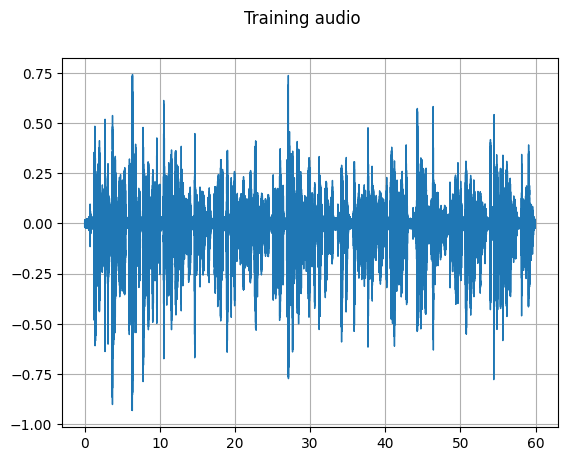

In [9]:
plot_waveform(train.SPEECH_WAVEFORM, train.SAMPLE_RATE, title="Training audio")
plt.show()

### Waveform of testing data

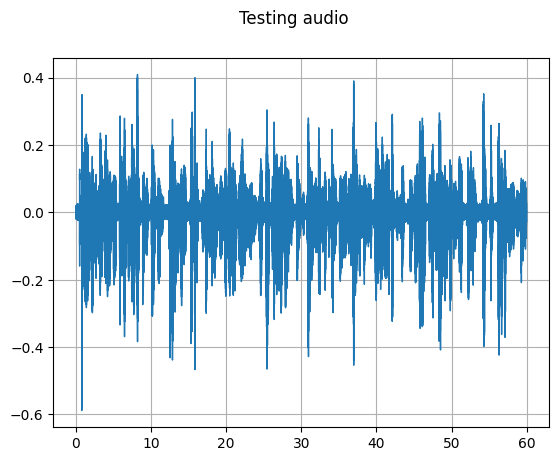

In [11]:
plot_waveform(test.SPEECH_WAVEFORM, test.SAMPLE_RATE, title="Testing audio")
plt.show()

In [ ]:
batch_size = 30

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

In [ ]:
class Bi_RNN(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=11, num_layers=2, rnn_type='LSTM'):
        """
        Arguments:
            input_dim: Input layer dimension
            hidden_dim: Hidden layer dimension
            batch_size: Batch size of data
            output_dim: Output layer dimension
            num_layers: Number of layers
            rnn_type: Type of RNN
        """
        super(Bi_RNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.init_linear = nn.Linear(self.input_dim, self.input_dim)
        self.lstm = eval('nn.' + rnn_type)(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(self.hidden_dim * 2, output_dim)

    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        linear_input = self.init_linear(input)
        lstm_out, self.hidden = self.lstm(linear_input)
        y_pred = self.linear(lstm_out)
        return y_pred

n_epochs = 2
lr = 0.01
n_folds = 5
lstm_input_size = 1
hidden_state_size = 30
num_sequence_layers = 2
output_dim = 11
num_time_steps = 4000
rnn_type = 'LSTM'
print_interval = 3000

model = Bi_RNN(lstm_input_size, hidden_state_size, batch_size, output_dim, num_sequence_layers, rnn_type)
model = model.to(device)

### Training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.BCEWithLogitsLoss()

for epoch in range(n_epochs):
    for i, (name, label) in enumerate(train):
        pass

### Testing

In [ ]:
num_correct = 0
num_samples = len(test)

model.eval()

with torch.no_grad():
    pass

print(f"Accuracy: {num_correct / num_samples * 100:.4f}%")